In [1]:
import sys
import os
from importlib import reload
here = os.getcwd()
sys.path.append(os.path.join(here,"../"))

In [2]:
#!/usr/bin/env python
# coding: utf-8

import dcarte

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score,accuracy_score,roc_auc_score,roc_curve
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree,export_text,export_graphviz
from sklearn.model_selection import train_test_split

import ast
import math
import operator

op_map = {'>=':operator.ge,'>':operator.gt,'<=':operator.le,'<':operator.lt,'==':operator.eq}


In [3]:
from utils.test_utils import make_results_filenames

from explainer.FPGrowth_tree import *
from explainer.rule_pattern_miner import *
from explainer.explainer_utils import *
import explainer.RuleGrowth_tree as rgtree


In [4]:
def encode_one_hot(df,col_name):
    df[col_name] = pd.Categorical(df[col_name])
    one_hot = pd.get_dummies(df[col_name])
    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(col_name,axis=1)
    return df

def min_max_normalization(df,col_name,min_val=None,max_val=None):
    if min_val is None:
        min_val = df[col_name].min()
    if max_val is None:
        max_val = df[col_name].max()
    df[col_name] = (df[col_name]-min_val)/(max_val-min_val)
    return df

def min_max_multicols(df,col_names,min_max_df=None):
    if min_max_df is None:
        min_max_df = pd.DataFrame(columns=col_names)
        min_max_df.loc["min"] = df.loc[:,min_max_df.columns].min(axis=0)
        min_max_df.loc["max"] = df.loc[:,min_max_df.columns].max(axis=0)
    for cn in col_names:
        df = min_max_normalization(df,cn,min_max_df.loc["min",cn],min_max_df.loc["max",cn])
    return df, min_max_df

def recover_feature_raw_value(fid,fval,featur_names,raw_min_max,ntype="min_max"):
    fn = featur_names[fid]
    if ntype == "min_max":
        if fn in raw_min_max.columns:
            mx = raw_min_max.loc[:,fn].max()
            mi = raw_min_max.loc[:,fn].min()
            return fval*(mx-mi)+mi
        return fval
    else:
        raise TypeError("Not yet supported type")

In [5]:
## control random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## set data path to load data
pp = "/Users/chenyu/github/NDE-Models-DigitalHealth/"
dpath = pp+"data/processed/diabetes_prediction_dataset.csv"

## set results path to save results
rpath = "./results/"
name = os.path.join(rpath,'diabetes')

In [6]:
## read diabetes dataset
df = pd.read_csv(dpath,header=1)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
## transform categorical feature to one-hot-encoder
df = encode_one_hot(df,'gender')
df = encode_one_hot(df,'smoking_history')
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,Female,Male,Other,No Info,current,ever,former,never,not current
0,80.0,0,1,25.19,6.6,140,0,1,0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80,0,1,0,0,1,0,0,0,0,0
2,28.0,0,0,27.32,5.7,158,0,0,1,0,0,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155,0,1,0,0,0,1,0,0,0,0
4,76.0,1,1,20.14,4.8,155,0,0,1,0,0,1,0,0,0,0


In [8]:
## split training and test set
X_train,X_test,y_train,y_test = train_test_split(df.drop('diabetes',axis=1),df['diabetes'],test_size=0.3,random_state=seed)

## min-max normalize numerical features
X_train,min_max = min_max_multicols(X_train,col_names=['age','bmi','HbA1c_level','blood_glucose_level'])
X_test,_ = min_max_multicols(X_test,col_names=min_max.columns,min_max_df=min_max)

In [9]:
## apply oversampling on training set 

from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=seed)
X_over, y_over = oversampler.fit_resample(X_train, y_train)

In [10]:
## train a logistic regression model and check performance on test set
log_reg = LogisticRegression(max_iter=2000,multi_class='ovr',random_state=seed)
log_reg.fit(X_over,y_over)
y_pred = log_reg.predict(X_test)


accuracy = log_reg.score(X_test,y_test)
confusion = confusion_matrix(y_test,y_pred)
precision = precision_score(y_test,y_pred,average=None)
recall = recall_score(y_test,y_pred,average=None)
accuracy,confusion,precision,recall

(0.8882666666666666,
 array([[24405,  3048],
        [  304,  2243]]),
 array([0.98769679, 0.42392742]),
 array([0.88897388, 0.88064389]))

In [11]:
## get baseline samples and test samples for computing impact scores of features

baselines = gen_intgrad_baselines(X_over.values,y_over.values)
subset = gen_balanced_subset(X_train.values,y_train.values,size_per_class=int(y_train.sum()))

In [12]:
## compute impact score matrix

C=2
baseline_output = log_reg.predict_proba(baselines)[:,1]
subset_output,yshift,int_g = [],[],[]    
cids = np.arange(C)
for k in cids:    
    subset_output.append(log_reg.predict_proba(subset[k])[:,1])
    for kk in cids[cids!=k]:
        yshift.append(subset_output[k]-baseline_output[kk])
        int_g.append((subset[k]-baselines[kk])* log_reg.coef_)
yshift = np.concatenate(yshift)
int_g = np.vstack(int_g)
y_int_g = np.abs(int_g)/yshift.reshape(-1,1)

In [13]:
## find threshold for impact score

thds = np.linspace(0.01,1.,1000)
f_n = []
for thd in thds:
    mask = np.abs(y_int_g) >= thd 
    f_n.append((thd,(mask.sum(axis=0)>=len(y_int_g)*0.99).sum()))
#     print(f_n[-1])
    if f_n[-1][1]==1:
        break
thd = f_n[-1][0]
thd

0.2527927927927928

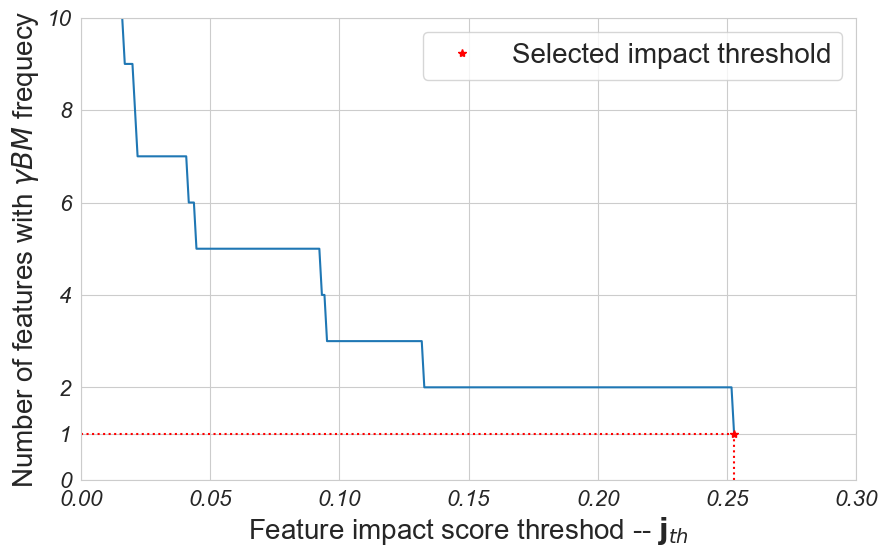

In [14]:
## plot the scanning process of finding threshold

import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot([th[0] for th in f_n[:]],[(th[1]) for th in f_n[:]])
plt.plot(f_n[-1][0],(f_n[-1][1]),"r*",label="Selected impact threshold")
plt.plot([0,f_n[-1][0]],[(f_n[-1][1]),(f_n[-1][1])],":r")
plt.plot([f_n[-1][0],f_n[-1][0]],[0,f_n[-1][1]],":r")
plt.xlim(0.,.3)
plt.ylim(0.,10)
plt.yticks([0,1,2,4,6,8,10],fontsize=16,fontstyle='italic')
plt.xticks(fontsize=16,fontstyle='italic')
plt.xlabel(r"Feature impact score threshod -- $\mathbf{j}_{th}$",fontsize=20)
plt.ylabel(r"Number of features with $\gamma BM$ frequecy",fontsize=20)
plt.legend(fontsize=20)
# plt.savefig("./results/diabetes/score_thd.svg",bbox_inches="tight")

In [15]:
## identify frequent important feature set

itemsets_y = transform_intgrad_to_itemsets(y_int_g,thd=thd,K=1)
fids = gen_freq_feature_set(itemsets_y[0],min_support=500,max_len=100)
fids = np.array(fids).astype(int)-1
print('feature set',fids,len(fids))

feature set [4 7 0 5 3 9 1 6 2] 9


auc 0.9621384460095029
y threshold 0.4571048952150361


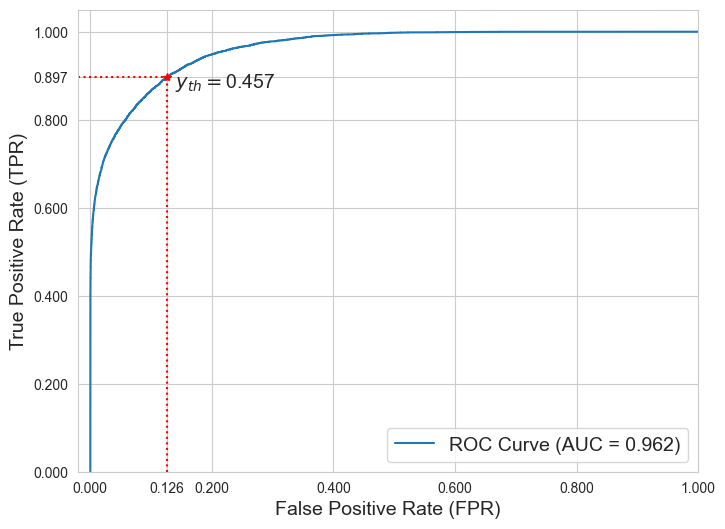

In [16]:
# from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt
# import scipy as sp

## find and plot the prediction threshold using ROC

pred_y = log_reg.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, pred_y)
print("auc",auc)

fpr, tpr, thresholds = roc_curve(y_train, pred_y)
th_id = np.argmax(tpr - fpr)
y_thd = thresholds[th_id]
print("y threshold",y_thd)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot(fpr[th_id],tpr[th_id],"r*")
plt.annotate('$y_{th}=$'+str(y_thd.round(3)), (fpr[th_id],tpr[th_id]), textcoords='offset points', xytext=(42,-8), ha='center',fontsize=14)

plt.plot([fpr[th_id],fpr[th_id]],[0,tpr[th_id]],"r:")
plt.plot([-0.02,fpr[th_id]],[tpr[th_id],tpr[th_id]],"r:")
plt.xlim(-0.02,1.)
plt.xticks([0.,fpr[th_id],0.2,0.4,0.6,0.8,1.])
plt.yticks([0.,0.2,0.4,0.6,0.8,tpr[th_id],1.])
plt.ylim(0,1.05)
plt.xlabel('False Positive Rate (FPR)',fontsize=14)
plt.ylabel('True Positive Rate (TPR)',fontsize=14)
plt.legend(fontsize=14)
# plt.savefig("./results/diabetes/roc.eps",bbox_inches="tight")

plt.show()

In [17]:
## check AUC on test set
pred_y_test = log_reg.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred_y_test)
auc

0.962387678432344

In [18]:
### search rules for target pattern: pred_y > y_thd  ###

import explainer.rule_pattern_miner as rlm

min_support=2500
num_grids=20
max_depth=1
top_K=3

y_rule_candidates = rlm.gen_rule_list_for_one_target(X_train.values,fids,pred_y>y_thd,y=y_train.values,c=1,sort_by="cond_prob_y",
                                                    min_support=min_support,num_grids=num_grids,max_depth=max_depth,top_K=top_K,
                                                    local_x=None,feature_types=None,
                                                    verbose=False)

for i, rules in enumerate(y_rule_candidates):   
    rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
    y_rule_candidates[i] = rules
y_rule_candidates

build_rule_tree
init rule tree
check potential rule 4 5.197658545796437 0.5789473684210527 1.0 2736
add rule [] 4 [5.197658545796437, 4]


[{'rules': [(4, 'HbA1c_level', '>=', 0.5789473684210527)],
  'cond_prob_target': 0.993421052631579,
  'support': 2736,
  'fitness': 0.20180880484341132,
  'cond_prob_y': 1.0,
  'ratio_y': 0.4596002015790358}]

In [19]:
## recover raw feature value by reversing the min-max normalization

for n in range(len(y_rule_candidates)):
    for i, r in enumerate(y_rule_candidates[n]["rules"]):
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        y_rule_candidates[n]["rules"][i] = (*r[:-1],nr) 
        print(y_rule_candidates[n])

{'rules': [(4, 'HbA1c_level', '>=', 6.684210526315789)], 'cond_prob_target': 0.993421052631579, 'support': 2736, 'fitness': 0.20180880484341132, 'cond_prob_y': 1.0, 'ratio_y': 0.4596002015790358}


In [20]:
import explainer.DT_rules as dtr
from explainer.DT_rules import obtain_rule_lists_from_DT,select_rule_list

### otain rules for target pattern: pred_y > y_thd from a DecisionTreeClassifier

input_feature_names =X_train.columns
treemodel = DecisionTreeClassifier(max_depth=max_depth,min_samples_leaf=min_support,random_state=seed)
treemodel.fit(X_train,pred_y>y_thd)
rule_list, rule_value_list, rule_metric_list, new_lines = dtr.obtain_rule_lists_from_DT(treemodel,5,X_train.values,y_train.values,pred_y>y_thd,np.arange(X_train.shape[-1]),X_train.columns,c=1)
print(export_text(treemodel))

|--- feature_4 <= 0.52
|   |--- class: False
|--- feature_4 >  0.52
|   |--- class: True



In [21]:
## recover raw feature value by reversing the min-max normalization
for s in range(len(rule_list)):
    for j, r in enumerate(rule_list[s]):
        nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
        rule_list[s][j] = (*r[:-1],nr)

In [22]:
## display rules extracted by DT classifier
dtr.display_rules_from_DT(rule_list,rule_metric_list,input_feature_names)

#################
[(4, '<=', 6.349)]
cond_prob_target 0.106 cond_prob_y 0.042 support 55499 fitness -3.265
HbA1c_level <= 6.349
#################
[(4, '>', 6.349)]
cond_prob_target 0.515 cond_prob_y 0.251 support 14501 fitness 0.033
HbA1c_level > 6.349


In [23]:
### extract local rules for specific test samples

## tids of test samples demonstrated in the paper: 4,15,144

tid = 4 
x = X_train.values
xi = X_test.values[tid,:]
pred_y_test[tid],y_test.values[tid]

(0.7857145247378382, 1)

In [24]:
local_rules = rlm.gen_rule_list_for_one_target(X_train.values,fids,pred_y>y_thd,y=y_train.values,c=1,sort_by="fitness",
                                                            min_support=2000,num_grids=100,max_depth=3,top_K=3,
                                                            local_x=xi,feature_types=None,search="greedy",
                                                            verbose=False)

build_rule_tree
init rule tree
check potential rule 5 3.131008579081214 0.5353535353535354 1.0 7620
add rule [] 5 [3.131008579081214, 5]
check potential rule 4 1.5127090467799313 0.48484848484848486 1.0 3166
add rule [5] 4 [1.5127090467799313, 4]
check potential rule 0 1.0991859105275177 0.4040404040404041 1.0 2616
add rule [5, 4] 0 [1.0991859105275177, 0]
check potential rule 3 1.0705435696314287 0.20202020202020204 1.0 2395
add rule [5, 4] 3 [1.0705435696314287, 3]
check potential rule 9 1.0596632612077432 0.0 0.98989898989899 2356
add rule [5, 4] 9 [1.0596632612077432, 9]
check potential rule 3 1.4026840792754955 0.26262626262626265 1.0 2005
add rule [5] 3 [1.4026840792754955, 3]
check potential rule 9 1.143766503206337 0.0 0.98989898989899 5302
add rule [5] 9 [1.143766503206337, 9]
check potential rule 4 1.4014767850568026 0.48484848484848486 1.0 2356
add rule [5, 9] 4 [1.4014767850568026, 4]
check potential rule 3 1.2168053853722374 0.24242424242424243 1.0 2082
add rule [5, 9] 3 [

In [25]:
## display the top local rule set

rules = local_rules[0]
rules["rules"] = rlm.replace_feature_names(rules["rules"],X_train.columns)
for i, r in enumerate(rules["rules"]):
    nr = recover_feature_raw_value(r[0],r[-1],X_train.columns,min_max)
    rules["rules"][i] = (*r[:-1],nr) 
rules

{'rules': [(5, 'blood_glucose_level', '>=', 197.77777777777777),
  (4, 'HbA1c_level', '>=', 6.166666666666667),
  (0, 'age', '>=', 32.370909090909095)],
 'cond_prob_target': 0.9950305810397554,
 'support': 2616,
 'fitness': 0.19358696464608716,
 'cond_prob_y': 0.7010703363914373,
 'ratio_y': 0.30807995968419283}